In [1]:
#| echo: false
using Markdown
using CairoMakie

post_theme = merge(theme_latexfonts(), Theme(palette = (color = to_colormap(:seaborn_muted6),)));

I was thinking, recently, about how venting from vessel blowdown is modelled for screening purposes and how, more often than not, it does not take into account the blowdown curve. This is something that could easily be incorporated for simple Gaussian dispersion, which is what I examine here.

## Background

The standard approach for assessing the consequences of a release from a pressure vessel is to[@ccps-1999 11]:

1. Identify the source model (gas, liquid, aerosol)
2. Calculate the mass release rate
3. Model the dispersion of the release

The mass release rate from a vessel blowdown is taken as the max release rate (at the start of the blowdown) and generally assumed to be constant[@ccps-1999 29-35]. While the standard references do acknowledge that the flow will decrease over time, this is typically not taken into account in the dispersion models. The one exception that I'm aware of is when modelling flaring due to vessel and pipeline blowdowns: sometimes an average flowrate is taken instead of the max, in which case the blowdown curve is used to derive that average. It is still a constant, though, for the purposes of dispersion modelling.

However, if we think back to the development of the Palazzi model[@palazzi-1982] for [short duration releases](/posts/integrated_puff/), a rather obvious path presents itself for the special case of a release of an ideal gas from an isothermal blowdown: integrate the Gaussian puff model over time with an exponentially decaying  mass release rate.

### Isothermal Blowdown

Recalling the [isothermal blowdown of an ideal gas](/posts/vessel_blowdown_ideal_gases/), the mass release rate, $w$, is given by

$$
w\left(t\right) = w_0 \exp \left( - \frac{t}{\tau} \right)
$$

Where[^massflow]

$$
w_0 = { {\rho_0 V} \over \tau }
$$

[^massflow]: This follows from the definition of $\tau$:
    $$ \tau = {m_0 \over w_0} $$
    $$ w_0 = {m_0 \over \tau} $$
    $$ w_0 = { {\rho_0 V} \over \tau }$$

For a blowdown through an isentropic nozzle the time constant $\tau$ is given by

$$
\frac{1}{\tau} = \frac{c_D A}{V} \sqrt{ {k P_0} \over \rho_0 } \left( 2 \over {k+1} \right)^{\frac{k+1}{2 \left( k - 1 \right)} }
$$

With:

- $c_D$ -- the discharge coefficient for the blowdown
- $A$ -- the flow area of the orifice through which the blowdown is happening (e.g. a PSV)
- $V$ -- the total volume of the vessel
- $k$ -- the [isentropic expansion factor](http://localhost:5866/posts/relief_valve_sizing/#the-isentropic-expansion-factor), which for an ideal gas is the ratio of specific heats $\frac{c_p}{c_v}$
- $P_0$ -- the initial pressure in the vessel
- $\rho_0$ -- the initial density of the gas in the vessel


### The Single Puff Model

For a release centred at the origin with an elevation *h*, the concentration profile for a single Gaussian puff is given by[@ccps-1999 90-91]:

$$
c \left(x,y,z,t \right) = w \Delta t \cdot g_x(x, t) \cdot g_y(y) \cdot g_z(z)
$$

Where the *g*s are Gaussian functions in the x, y, and z directions

$$
g_x(x,t) = {1 \over \sqrt{2\pi} \sigma_x } \exp \left( -\frac{1}{2} \left( x-u t \over \sigma_x \right)^2 \right)
$$

In [2]:
#| output: false
gx(x,t,u,σx) = exp(-0.5*((x-u*t)/σx)^2)/(√(2π)*σx)

gx (generic function with 1 method)

$$
g_y(y) = {1 \over \sqrt{2\pi} \sigma_y } \exp \left( -\frac{1}{2} \left( y \over \sigma_y \right)^2 \right)
$$

In [3]:
#| output: false
gy(y,σy) = exp(-0.5*(y/σy)^2)/(√(2π)*σy)

gy (generic function with 1 method)

$$
g_z(z) = {1 \over \sqrt{2\pi} \sigma_z } \left[ \exp \left( -\frac{1}{2} \left( z-h \over \sigma_z \right)^2 \right) + \exp \left( -\frac{1}{2} \left( z+h \over \sigma_z \right)^2 \right) \right]
$$

In [4]:
#| output: false
gz(z,h,σz) = (  exp(-0.5*((z-h)/σz)^2)
              + exp(-0.5*((z+h)/σz)^2))/(√(2π)*σz)

gz (generic function with 1 method)

With:

- $w$ -- the constant mass release rate
- $\Delta t$ -- the duration of the release
- $u$ -- the uniform windspeed (acting only in the x direction)
- $\sigma$s -- the dispersion parameters.

For puff releases, the dispersion parameters are typically given in reference to the centre of the cloud[@ccps-1999 90], here I have taken some puff dispersion parameters for a [class D atmospheric stability](https://en.wikipedia.org/wiki/Outline_of_air_pollution_dispersion#The_Pasquill_atmospheric_stability_classes).

In [5]:
#| output: false
# Puff dispersion parameters for Class D atmospheres
σx(xc) = 0.06*xc^0.92
σy(xc) = 0.06*xc^0.92
σz(xc) = 0.15*xc^0.70

σz (generic function with 1 method)

I like to use [Unitful](https://github.com/JuliaPhysics/Unitful.jl) to manage units. This can be a little tricky with correlations, so to make that easier I use [a simple macro](https://github.com/aefarrell/UnitfulCorrelations.jl) to add a method to each correlation function mapping the correct input units and output units.

```julia
import Pkg
Pkg.add(url="https://github.com/aefarrell/UnitfulCorrelations.jl")
```

In [6]:
using Unitful
using UnitfulCorrelations

In [7]:
#| output: false
@ucorrel σx u"m" u"m"
@ucorrel σy u"m" u"m"
@ucorrel σz u"m" u"m"

σz (generic function with 2 methods)

A good habit to get into, when developing code in julia, is to collect model parameters into structs. This is what I do here, collecting the parameters for a single Puff into a `Puff` struct.

In [8]:
#| output: false
struct Puff
    m # mass
    h # release height
    u # velocity
    t # release time
end

Now I create the concentration function which takes a single puff, and a location in space and time, and returns the concentration. I also check for the special case where the puff hasn't actually been released yet, and so does not contribute to the concentration.

Since I want this to be unit aware, both return values have to have the same units. I don't want to hard-code this as I may also want to use this function with simple numeric types, like `Float64`. By using the `unit` function I can ensure the zero result has the same dimensions as the correct result, falling back to no units in the case where all inputs are simple numbers.

In [9]:
#| output: false
function c(p::Puff,x,y,z,t)
    λ  = t - p.t # time since release
    xc = p.u*λ   # location of cloud center
    if λ > 0t 
        return p.m*gx(x,λ,p.u,σx(xc))*gy(y,σy(xc))*gz(z,p.h,σz(xc))
    else # the puff hasn't been released yet
        return 0*unit(p.m)/unit(xc)^3
    end
end

c (generic function with 1 method)

### The Multi-Puff Model

The single puff model assumes all of the mass is released in a single instant. This significantly over-estimates the concentration for longer duration releases, and so an alternative approach is to break up the release into [several puffs](/posts/integrated_puff/) and sum the result.

$$
c(x,y,z,t) = \sum_{i=0}^{n}  w\left( t_i \right) \delta t \cdot g_x(x, t - t_i ) \cdot g_y(y) \cdot g_z(z)
$$

Where $\delta t$ is the duration of each puff and $t_i$ is the time when puff *i* was released.

In [10]:
#| output: false
c(ps::Vector{Puff},x,y,z,t) = sum( c.(ps, x, y, z, t) );

Taking the limit $\delta t \to 0$ takes this from a discrete sum to the corresponding integral

$$
c(x,y,z,t) = \int_{0}^{t} w\left( t^{\prime} \right) \cdot g_x(x, t - t^{\prime}) \cdot g_y(y) \cdot g_z(z) dt^{\prime}
$$

For the Palazzi[@palazzi-1982] model $w(t) = w_0 \left( H\left(t - \Delta t \right) - H\left( t \right) \right)$[^heaviside] and, assuming the $\sigma$s are independent of time, this can be integrated to give:

$$
c(x,y,z,t) = \frac{w_0}{2u} \left( \mathrm{erf}\left({ {x - u (t-\Delta t)} \over \sqrt{2} \sigma_x }\right) - \mathrm{erf}\left( { {x - u t} \over \sqrt{2} \sigma_x } \right) \right) \cdot g_y(y) \cdot g_z(z)
$$

[^heaviside]: $H \left(t \right)$ being the [Heaviside function](https://mathworld.wolfram.com/HeavisideStepFunction.html)

In [11]:
#| output: false
using SpecialFunctions: erf, erfc

In [12]:
#| output: false
struct Palazzi
    w   # mass release rate
    h   # release height
    u   # velocity
    t_f # end of release
end

In [13]:
#| output: false
function c(p::Palazzi,x,y,z,t)
    Δt = min(t, p.t_f)
    w, u = p.w, p.u
    xa = u*(t-Δt)
    xb = u*t
    # n.b. erf(b,a) = erf(a) - erf(b)
    return (w/(2u))*erf((x-xb)/(√2*σx(xb)), (x-xa)/(√2*σx(xa))) *
            gy(y,σy(x))*gz(z,h,σz(x))
end

c (generic function with 3 methods)

## A Blowdown Dispersion Model

It should be pretty obvious where I am going next: instead of assuming $w(t)$ is a constant, let it be the exponential decay from an isothermal vessel blowdown. The integration is a little more tedious but it is not really any more difficult than the Palazzi case.

$$
c(x,y,z,t) = \int_{0}^{t} w\left( t^{\prime} \right) \cdot g_x(x, t - t^{\prime}) \cdot g_y(y) \cdot g_z(z) dt^{\prime}
$$

$$
c(x,y,z,t) = \int_{0}^{t} \left[ w_0 \exp\left( -{t^{\prime} \over \tau} \right) \right] \cdot \left[ {1 \over \sqrt{2\pi} \sigma_x } \exp \left( -\frac{1}{2} \left( x-u (t - t^{\prime}) \over \sigma_x \right)^2 \right) \right] \cdot g_y(y) \cdot g_z(z) dt^{\prime}
$$

Splitting this into elements that depend on time and those that don't
$$
c(x,y,z,t) = w_0 \left[ \int_{0}^{t} {1 \over \sqrt{2\pi} \sigma_x } \exp\left( -{t^{\prime} \over \tau} -\frac{1}{2} \left( x-u (t - t^{\prime}) \over \sigma_x \right)^2 \right) dt^{\prime} \right] \cdot g_y(y) \cdot g_z(z) 
$$

Letting everything within the integral equal $I(x,t)$

$$
c(x,y,z,t) = w_0 \cdot I(x,t) \cdot g_y(y) \cdot g_z(z) 
$$

It makes the integration a little easier to introduce $\lambda = t-t^{\prime}$

$$
I(x,t) = \int_{0}^{t} {1 \over \sqrt{2\pi} \sigma_x } \exp\left( -{{t - \lambda} \over \tau} -\frac{1}{2} \left( x-u \lambda \over \sigma_x \right)^2 \right) d\lambda
$$

By expanding everything within the $\exp(\dots)$, collecting terms and completing the square we arrive at:

$$
I(x,t) = {1 \over \sqrt{2\pi} \sigma_x } \exp \left( {\sigma_x^2 + 2 u \tau (x - u t)} \over {2 u^2 \tau^2} \right) \int_{0}^{t} \exp\left( -\left( {\sigma_x^2 + u \tau ( x - u \lambda ) } \over {\sqrt{2} \sigma_x u \tau} \right)^2 \right) d\lambda
$$

$$
I(x,t) = \frac{1}{2u} \exp \left( {\sigma_x^2 + 2 u \tau (x - u t)} \over {2 u^2 \tau^2} \right) \left[ \mathrm{erf}\left( {\sigma_x^2 + u \tau x} \over {\sqrt{2} \sigma_x u \tau} \right) - \mathrm{erf}\left( {\sigma_x^2 +  u \tau (x - u t)} \over {\sqrt{2} \sigma_x  u \tau} \right)\right]
$$

If we evaluate the $\sigma_x$s at the end points then, given that $\sigma_x \to 0$ as $x_c \to 0$, this simplifies to:

$$
I(x,t) = \frac{1}{2u} \exp \left( {\sigma_x^2 + 2 u \tau (x - u t)} \over {2 u^2 \tau^2} \right) \mathrm{erfc}\left( {\sigma_x^2 +  u \tau (x - u t)} \over {\sqrt{2} \sigma_x  u \tau} \right)
$$

Giving a final concentration of:

$$
c(x,y,z,t) = \frac{w_0}{2u} \exp \left( {\sigma_x^2 + 2 u \tau (x - u t)} \over {2 u^2 \tau^2} \right) \mathrm{erfc}\left( {\sigma_x^2 +  u \tau (x - u t)} \over {\sqrt{2} \sigma_x  u \tau} \right) \cdot g_y(y) \cdot g_z(z)
$$

In [14]:
#| output: false
struct IsothermalBlowdown
    w_0   # mass release rate
    τ     # time constant
    h     # release height
    u     # velocity
    t_f   # end of release
end

In [15]:
#| output: false
function c(p::IsothermalBlowdown,x,y,z,t)
    w₀, u, τ = p.w_0, p.u, p.τ
    xb = u*t
    xa = t < p.t_f ? 0*xb : u*(t-p.t_f)
    return (w₀/(2u))*
            exp( (σx(xb)^2 + 2u*τ*(x - xb))/(2*(u*τ)^2) ) *
            erf( (σx(xb)^2 + u*τ*(x - xb))/(√(2)*σx(xb)*u*τ),
                 (σx(xa)^2 + u*τ*(x - xa))/(√(2)*σx(xa)*u*τ) )*
            gy(y,σy(x))*gz(z,h,σz(x))
end

c (generic function with 4 methods)

::: {.callout-note}
Note that I have implemented a slightly different version of the model. In the case where $t < t_f$, with $t_f$ being the time at which the blowdown ceases, this simplifies to the model given above, where I implicitly assumed $t_f \to \infty$. 

In the case where $t_f$ is some finite number and $t \ge t_f$, an extra term is added to, essentially, "turn off" the blowdown.
:::

### An Example Case

Just to have something to look at, suppose an isothermal blowdown from a vessel which starts at an initial release rate of 1kg/s and the vessel contains 1000kg of an ideal gas. The vent stack is 2m above the ground and ambient windspeed is 2m/s.

In [16]:
#| output: false
# The example case
u  = 2.0u"m/s"
h  = 2.0u"m"
w₀ = 1.0u"kg/s"
m₀ = 1000.0u"kg"
τ  = m₀/w₀

1000.0 s

The mass release rate, per above, is simply the exponential decay.

In [17]:
#| output: false
w(t) = w₀*exp(-t/τ)

w (generic function with 1 method)

The total mass released by time *t* is simply the time-integral:

$$
m(t) = \int_0^t w_0 \exp \left( -\frac{t^{\prime}}{\tau} \right) d t^{\prime}
$$

$$
m(t) = w_0 \tau \left( 1 - \exp \left( -\frac{t^{\prime}}{\tau} \right) \right)
$$

In [18]:
#| output: false
m(t) = w₀*τ*(1 - exp(-t/τ))

m (generic function with 1 method)

### Discrete Puffs

Suppose that after $\tau$ time has elapsed a block-valve shuts and the release abruptly ends. This release can be modelled as a series of discrete puffs by dividing the interval $[ 0, \tau )$ into $n$ sub-intervals and releasing a single puff at the start of each interval *i* with a mass $m_i = w(t_i) \delta t$.

In [19]:
#| output: false
function discrete_puffs(;n=100, t_0=0τ, t_f=τ)
    δt = (t_f - t_0)/(n-1)
    pfs = Vector{Puff}()
    for t_i ∈ range(t_0;stop=t_f,length=n)
        m_i = w(t_i)*δt
        pf = Puff(m_i,h,u,t_i)
        push!(pfs,pf)
    end
    return pfs
end

discrete_puffs (generic function with 1 method)

In [20]:
pfs = discrete_puffs(n=25);

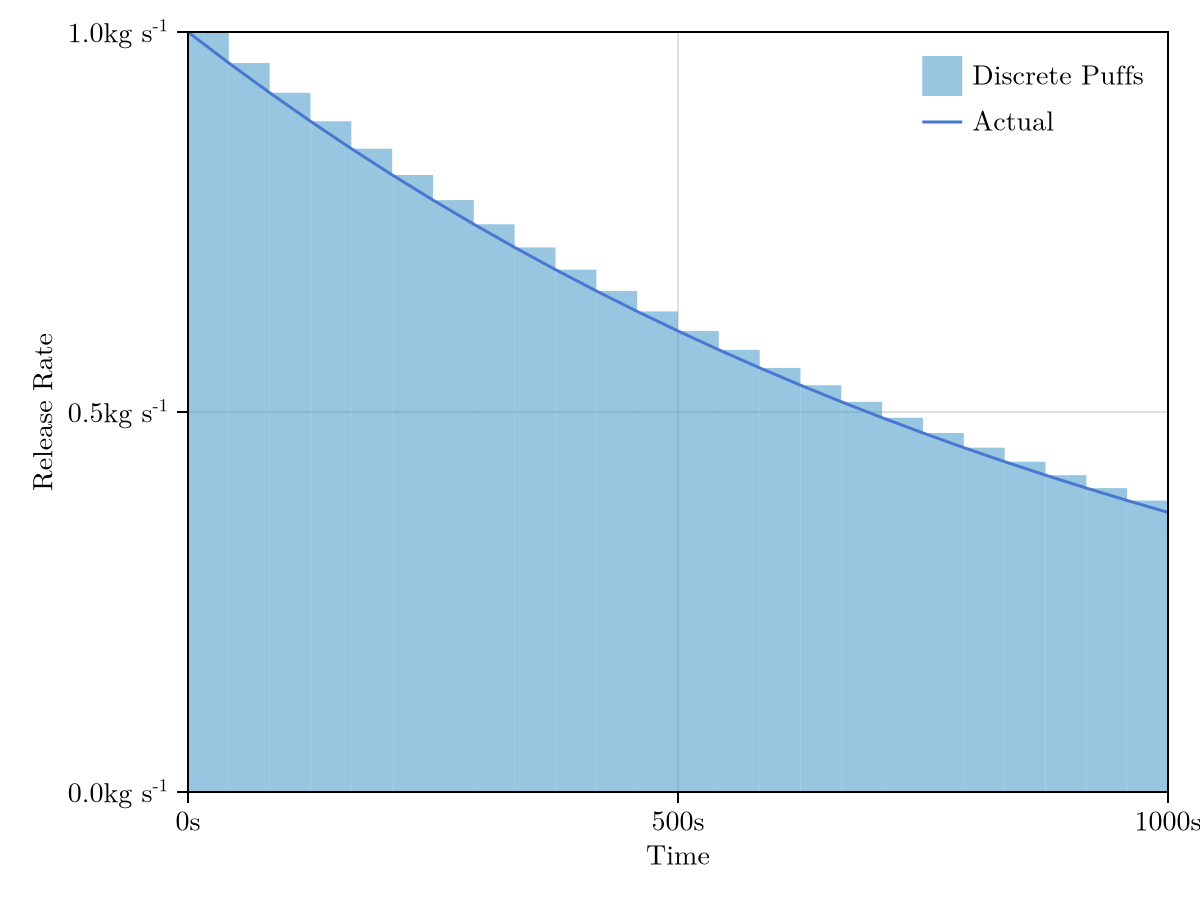

In [21]:
#| echo: false
#| label: fig-mass-1
#| fig-cap: "The release rate for an isothermal vessel blowdown, along with the sequence of discrete puffs generated to approximate it."
with_theme(post_theme) do
    δt = τ/(length(pfs)-1)
    ts = [pf.t for pf in pfs]
    pfw = [ pf.m/δt for pf in pfs ]
    
    f = Figure()
    ax = Axis(f[1, 1],
        xlabel = "Time",
        ylabel = "Release Rate",
        dim1_conversion = Makie.UnitfulConversion(u"s"; units_in_label=true),
        dim2_conversion = Makie.UnitfulConversion(u"kg/s"; units_in_label=true),
        limits = ((0,ustrip(u"s",τ)),(0,1)),
    )
    barplot!(ax, ts .+ 0.5δt, pfw, gap=0, label="Discrete Puffs", alpha=0.5)
    lines!(ax, ts, w.(ts), label="Actual")
    axislegend(ax; framevisible = false, position=:rt)
    
    f
end

For the purposes of illustration I chose a rather small number of puffs, as shown in [@fig-mass-1]. However, if we calculate the total mass released we find that it isn't too far off.

In [22]:
m(pfs::Vector{Puff},t) = sum( pf.m for pf in pfs if pf.t < t );

In [23]:
#| echo: false
let

overestimate = (m(pfs,τ)/m(τ) -1)*100

display(Markdown.parse("""
        After time τ has elapsed, the total released mass is 
        $(round(typeof(1u"kg"),m(τ))), the total mass of the 
        discrete puffs is $(round(typeof(1u"kg"),m(pfs,τ))), 
        an excess of only $(round(overestimate;digits=1))%.
        """))

end

After time τ has elapsed, the total released mass is  632 kg, the total mass of the  discrete puffs is 645 kg,  an excess of only 2.1%.


### Comparing Results

With the discrete puff case implemented, we can now compare with the approximate integral. Recall that I didn't actually integrate the full expression, I *approximated* the integral as one where the $\sigma$s are constant (they aren't) and integrated *that*. I then took that result and substituted back in the correlations for the $\sigma$s. The hope is that this will be close enough to the full expression that we can use it.

For a less than rigorous approach, let us consider a point 1000m downwind of the vent stack, at the same release height as the stack. We will look at the concentration profile over time at that point.

Another useful comparison is to the Palazzi model, we expect the concentration profile for the blowdown to be bounded between the Palazzi case with a constant mass rate $w = w_0$ and the case with a constant mass rate $w = w(\tau)$. Furthermore, we expect the blowdown case should connect the two curves with something resembling an exponential decay.

In [24]:
#| output: false
bd = IsothermalBlowdown(w₀,τ,h,u,τ)

IsothermalBlowdown(1.0 kg s^-1, 1000.0 s, 2.0 m, 2.0 m s^-1, 1000.0 s)

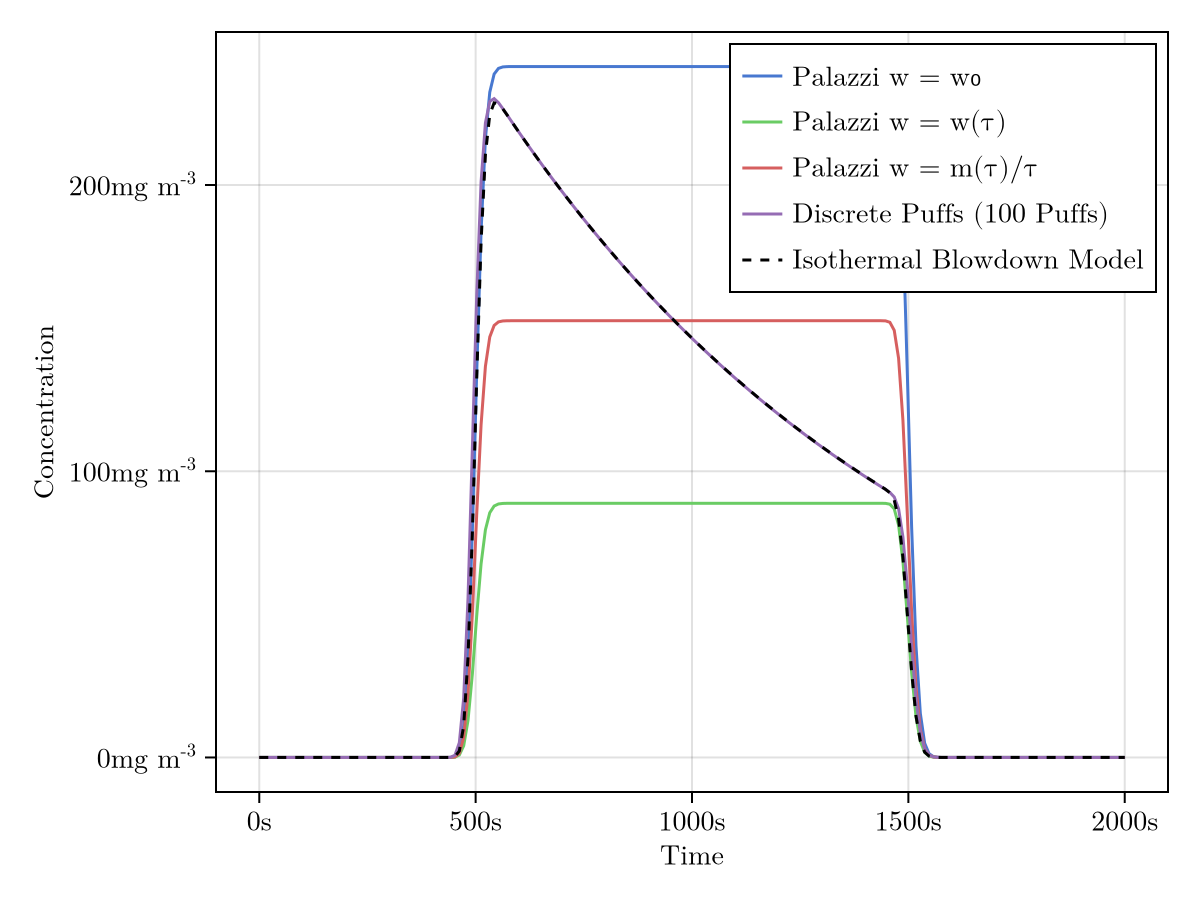

In [25]:
#| echo: false
#| label: fig-puffs-1
#| fig-cap: "The concentration profile at x=1000m, y=0m, z=2m."

with_theme(post_theme) do
    x = 0.5*u*τ
    ts = LinRange(0τ, 2τ, 200)

    plmx = Palazzi(w(0τ),h,u,τ)
    c_plmx = [ c(plmx,x,0h,h,t) for t in ts ];
    
    plmn = Palazzi(w(τ),h,u,τ)
    c_plmn = [ c(plmn,x,0h,h,t) for t in ts ];
    
    pla = Palazzi(m(τ)/τ,h,u,τ)
    c_pla = [ c(pla,x,0h,h,t) for t in ts ];

    c_bd = [ c(bd,x,0h,h,t) for t in ts ];
    
    f = Figure()
    ax = Axis(f[1, 1],
        xlabel = "Time",
        ylabel = "Concentration",
        dim1_conversion = Makie.UnitfulConversion(u"s"; units_in_label=true),
        dim2_conversion = Makie.UnitfulConversion(u"mg/m^3"; units_in_label=true),
        #limits = ((1/1000,ustrip(u"km",1.2u*τ)),(0,1000)),
    )
    
    lines!(ax, ts, c_plmx, label="Palazzi w = w₀")
    lines!(ax, ts, c_plmn, label="Palazzi w = w(τ)")
    lines!(ax, ts, c_pla, label="Palazzi w = m(τ)/τ")
    
    pfs = discrete_puffs(;n=100,t_f=τ)
    lines!(ax, ts, [ c(pfs,x,0*x,h,t) for t in ts ], 
               label="Discrete Puffs ($(length(pfs)) Puffs)")

    lines!(ax, ts, c_bd, label="Isothermal Blowdown Model", 
               color=:black, linestyle=:dash)
    
    axislegend(ax; framevisible=true, position=:rt)
    
    f
end

The results are showin in [@fig-puffs-1] above, which matches our expectations. The approximate integral model developed here is virtually identical to the discrete puffs model with 100 puffs. For comparison I also included the case where the Palazzi model is used but with a time-averaged constant release rate. This will have the correct total mass in the release, but clearly underestimates the peak concentration.

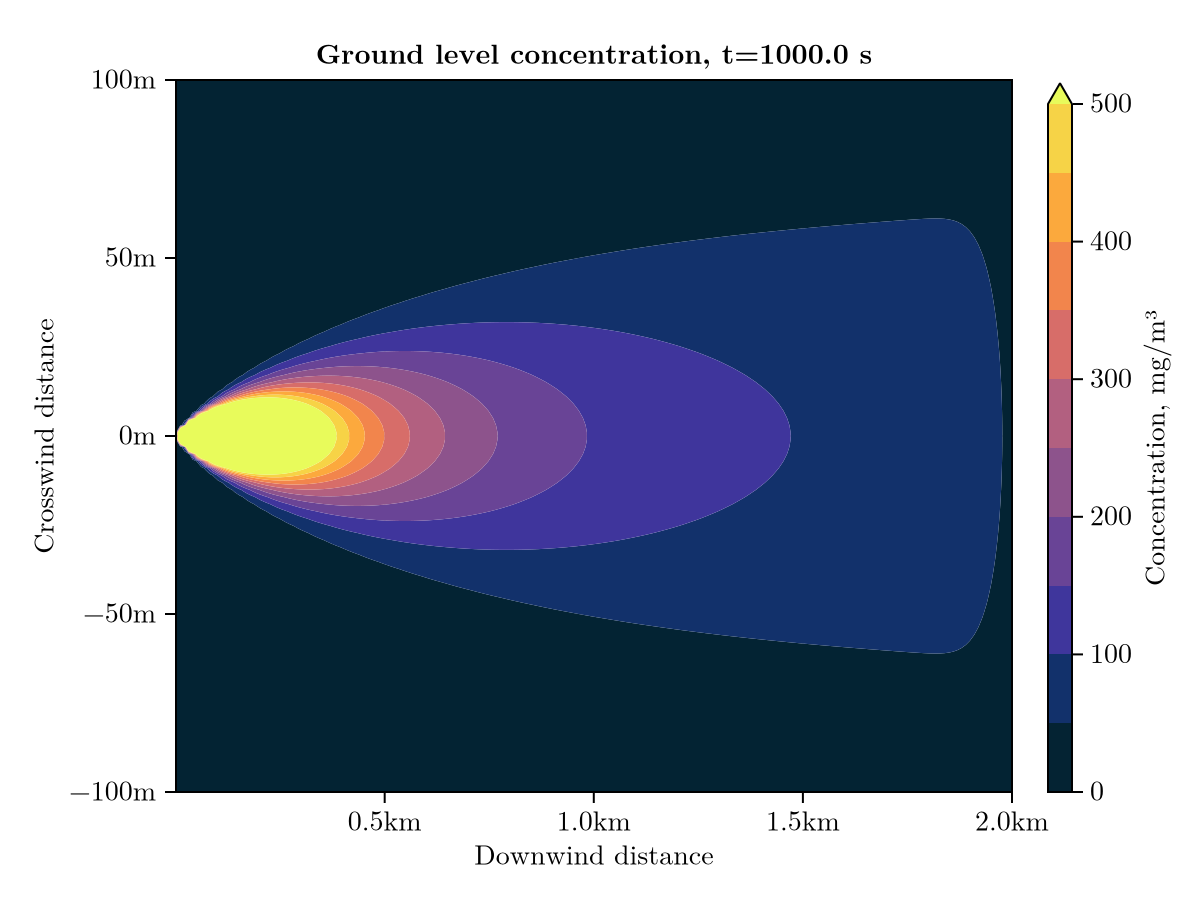

In [26]:
#| echo: false
#| label: fig-puffs-2
#| fig-cap: "The ground level concentration for the isothermal blowdown."

with_theme(post_theme) do

    xs = LinRange(1u"m",u*τ,200)
    ys = LinRange(-100u"m",100u"m",100)
    cs = [ c(bd,x,y,0h,τ) for x in xs, y in ys]
    cs = uconvert.(u"mg/m^3",cs)
    
    f = Figure()
    ax = Axis(f[1,1],
            title = "Ground level concentration, t=$(τ)",
            xlabel = "Downwind distance",
            ylabel = "Crosswind distance",
            dim1_conversion = Makie.UnitfulConversion(u"km"; units_in_label=true),
            dim2_conversion = Makie.UnitfulConversion(u"m"; units_in_label=true),
            limits = ((1/1000,ustrip(u"km",u*τ)),(-100,100)))
    
    levels = Makie.get_tickvalues(Makie.LinearTicks(10), 0, 500)
    
    ctr = contourf!(ax, xs, ys, cs, 
                  levels=levels, colormap=(:thermal, 1.0), transparency=false,
                  extendhigh = :auto)
    
    Colorbar(f[1, 2], ctr, label="Concentration, mg/m³")
    
    f
end

The ground level concentration also conforms to our expectations, as shown in [@fig-puffs-2]. The region around the vent itself, besides having some artifacts of the discretization and marching squares, is likely quite unreliable. This is the region where the fundamental assumptions, that the release has zero momentum and no buoyancy, are most egregiously violated. I think this model is still reasonable for concentrations far enough from the vent that the windspeed dominates the advection, though an *effective* release point would need to be used.

## A Note on Sources

It is the nature of the universe that the instant I post this I will find where this model was published in the literature. I haven't found it *yet*, but I can't imagine I am first person to come up with this. Knowing me, it is probably in one of the references I look at all the time and, somehow, failed to notice.

If this paragraph is still here when you see this, and you know of a published reference for this model, please leave a comment.

## References

::: {#refs}
:::